## RandomForestClassifier

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
# from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve
from sklearn.tree import DecisionTreeClassifier 
# from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder
# from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import re
# from scipy.sparse import csr_matrix, hstack, vstack
%matplotlib inline

In [3]:
RANDOM_STATE = 5
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

In [4]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [19]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')
train = train.drop(['Name', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Embarked'], axis=1)
test = test.drop(['Name', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Embarked'], axis=1)
# train = pd.concat([train, train_embarked], axis=1)
# test = pd.concat([test, test_embarked], axis=1)
y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)
X_test = test.copy()
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1})
X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1})

In [20]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].median())

In [21]:
mean_1 = X_train[X_train['Pclass'] == 1]['Fare'].mean()
std_1 = X_train[X_train['Pclass'] == 1]['Fare'].std()
fare_no_out_1 = X_train[X_train['Pclass'] == 1]['Fare'].apply(lambda x: x if (x < mean_1 + 2 * std_1) and \
                                                            (x > mean_1 - 2 * std_1) else mean_1)
mean_2 = X_train[X_train['Pclass'] == 2]['Fare'].mean()
std_2 = X_train[X_train['Pclass'] == 2]['Fare'].std()
fare_no_out_2 = X_train[X_train['Pclass'] == 2]['Fare'].apply(lambda x: x if (x < mean_2 + 2 * std_2) and \
                                                            (x > mean_2 - 2 * std_2) else mean_2)
mean_3 = X_train[X_train['Pclass'] == 3]['Fare'].mean()
std_3 = X_train[X_train['Pclass'] == 3]['Fare'].std()
fare_no_out_3 = X_train[X_train['Pclass'] == 3]['Fare'].apply(lambda x: x if (x < mean_3 + 2 * std_3) and \
                                                            (x > mean_3 - 2 * std_3) else mean_3)

X_train['Fare'] = pd.concat([fare_no_out_1, fare_no_out_2, fare_no_out_3])

In [22]:
fare_no_out_1 = X_test[X_test['Pclass'] == 1]['Fare'].apply(lambda x: x if (x < mean_1 + 2 * std_1) and \
                                                            (x > mean_1 - 2 * std_1) else mean_1)
fare_no_out_2 = X_test[X_test['Pclass'] == 2]['Fare'].apply(lambda x: x if (x < mean_2 + 2 * std_2) and \
                                                            (x > mean_2 - 2 * std_2) else mean_2)
fare_no_out_3 = X_test[X_test['Pclass'] == 3]['Fare'].apply(lambda x: x if (x < mean_3 + 2 * std_3) and \
                                                            (x > mean_3 - 2 * std_3) else mean_3)
X_test['Fare'] = pd.concat([fare_no_out_1, fare_no_out_2, fare_no_out_3])

In [23]:
X, y = X_train, y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_STATE)

In [53]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'Fare'], dtype='object')

In [24]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
y_preds = forest_clf.predict(X_valid)
print('ROC AUC:', roc_auc_score(y_preds, y_valid))

ROC AUC: 0.8191036693191865


In [37]:
# loo = KFold(n_splits=X_train.shape[0])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
forest_clf = RandomForestClassifier()
gs = GridSearchCV(estimator=forest_clf, param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                                   'n_estimators':[100, 200, 300, 400, 500]}, 
                  scoring='accuracy', cv=skf)
gs.fit(X_train, y_train);
gs.best_params_

{'max_depth': 6, 'n_estimators': 300}

In [46]:
forest_clf = RandomForestClassifier(max_depth=6, n_estimators=300)
forest_clf.fit(X_train, y_train)
y_preds = forest_clf.predict(X_valid)
print('ROC AUC:', roc_auc_score(y_preds, y_valid))

ROC AUC: 0.8491279069767441


In [49]:
forest_clf = RandomForestClassifier(max_depth=6, n_estimators=300)
forest_clf.fit(X, y)
y_preds = forest_clf.predict(X_test)

### Submission #001 

In [50]:
y_fin = pd.DataFrame(y_preds, columns=['Survived'], index=X_test.index)

In [51]:
y_fin.Survived.value_counts()

0    286
1    132
Name: Survived, dtype: int64

In [52]:
y_fin.to_csv('submissions/randomforest_001.csv', header=True, index_label='PassengerId')

In [74]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []

trees_grid = [10, 50, 100, 200, 300, 400, 500, 600]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees,
                                 max_depth=7, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1, 
                                 oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
        rfc.fit(X_train_, y_train_)
        temp_train_acc.append(rfc.score(X_train_, y_train_))
        temp_test_acc.append(rfc.score(X_test_, y_test_))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [75]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 82.55% with 50 trees


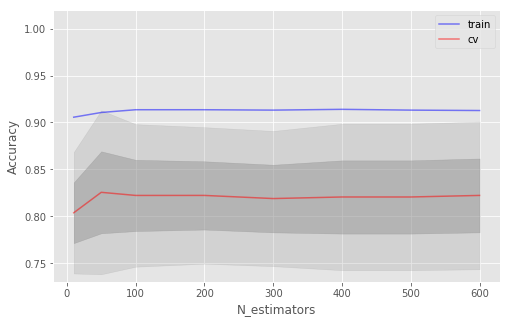

In [76]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.73,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

In [77]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1, 
                                 oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
        rfc.fit(X_train_, y_train_)
        temp_train_acc.append(rfc.score(X_train_, y_train_))
        temp_test_acc.append(rfc.score(X_test_, y_test_))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    

Best accuracy on CV is 81.88% with 7 max_depth


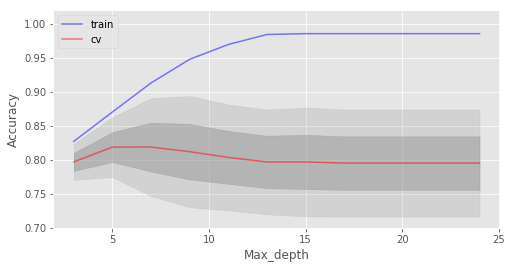

In [78]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

In [81]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, 
                                 n_jobs=-1, oob_score=True, 
#                                  max_depth=7,
                                 min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
        rfc.fit(X_train_, y_train_)
        temp_train_acc.append(rfc.score(X_train_, y_train_))
        temp_test_acc.append(rfc.score(X_test_, y_test_))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    

Best accuracy on CV is 81.72% with 5 min_sample_leaf


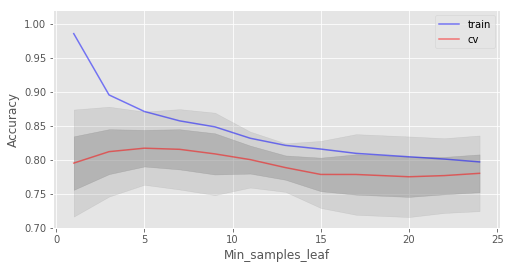

In [82]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_sample_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

In [84]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
max_features_grid = [2, 3, 4]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=300, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1, 
                                 oob_score=True, 
                                 max_depth=7,
                                 min_samples_leaf=5,
                                 max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_, y_test_ = y_train.iloc[train_index], y_train.iloc[test_index]
        rfc.fit(X_train_, y_train_)
        temp_train_acc.append(rfc.score(X_train_, y_train_))
        temp_test_acc.append(rfc.score(X_test_, y_test_))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    

Best accuracy on CV is 82.05% with 2 max_features


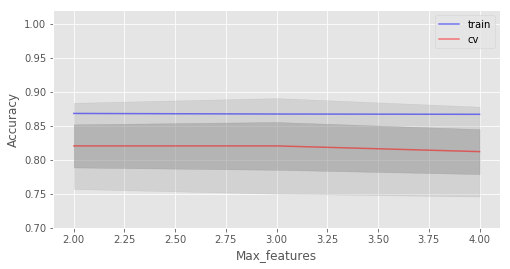

In [85]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.70,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

### #002

In [21]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')
# train = train.drop(['Name', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Embarked'], axis=1)
# test = test.drop(['Name', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Embarked'], axis=1)
y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)
X_test = test.copy()
X_train['Sex'] = X_train['Sex'].map({'male': 0, 'female': 1})
X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1})

In [22]:
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].median())
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].median())

In [23]:
mean_1 = X_train[X_train['Pclass'] == 1]['Fare'].median()
std_1 = X_train[X_train['Pclass'] == 1]['Fare'].std()
fare_no_out_1 = X_train[X_train['Pclass'] == 1]['Fare'].apply(lambda x: x if (x < mean_1 + 2 * std_1) and \
                                                            (x > mean_1 - 2 * std_1) else mean_1)
mean_2 = X_train[X_train['Pclass'] == 2]['Fare'].median()
std_2 = X_train[X_train['Pclass'] == 2]['Fare'].std()
fare_no_out_2 = X_train[X_train['Pclass'] == 2]['Fare'].apply(lambda x: x if (x < mean_2 + 2 * std_2) and \
                                                            (x > mean_2 - 2 * std_2) else mean_2)
mean_3 = X_train[X_train['Pclass'] == 3]['Fare'].median()
std_3 = X_train[X_train['Pclass'] == 3]['Fare'].std()
fare_no_out_3 = X_train[X_train['Pclass'] == 3]['Fare'].apply(lambda x: x if (x < mean_3 + 2 * std_3) and \
                                                            (x > mean_3 - 2 * std_3) else mean_3)

X_train['Fare'] = pd.concat([fare_no_out_1, fare_no_out_2, fare_no_out_3])

In [24]:
fare_no_out_1 = X_test[X_test['Pclass'] == 1]['Fare'].apply(lambda x: x if (x < mean_1 + 2 * std_1) and \
                                                            (x > mean_1 - 2 * std_1) else mean_1)
fare_no_out_2 = X_test[X_test['Pclass'] == 2]['Fare'].apply(lambda x: x if (x < mean_2 + 2 * std_2) and \
                                                            (x > mean_2 - 2 * std_2) else mean_2)
fare_no_out_3 = X_test[X_test['Pclass'] == 3]['Fare'].apply(lambda x: x if (x < mean_3 + 2 * std_3) and \
                                                            (x > mean_3 - 2 * std_3) else mean_3)
X_test['Fare'] = pd.concat([fare_no_out_1, fare_no_out_2, fare_no_out_3])

In [25]:
X_train['Embarked'] = X_train['Embarked'].fillna('S')
X_test['Embarked'] = X_test['Embarked'].fillna('S')

In [26]:
X_train.drop(['Ticket', 'Cabin', 'Name'], axis=1, inplace=True)
X_test.drop(['Ticket', 'Cabin', 'Name'], axis=1, inplace=True)

In [27]:
quantiles = tuple(X_train['Age'].quantile([0., 0.25, 0.5, 0.75, 1.]))
X_train['Age'] = pd.cut(X_train['Age'], quantiles, labels=[0, 1, 2, 3], include_lowest=True)
X_test['Age'] = pd.cut(X_test['Age'], quantiles, labels=[0, 1, 2, 3], include_lowest=True)
X_test['Age'] = X_test['Age'].fillna(3)

In [28]:
X_train['Embarked'] = X_train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
X_test['Embarked'] = X_test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [29]:
X_train['IsAlone'] = X_train[['SibSp', 'Parch']].sum(axis=1).apply(lambda x: 0 if x > 0 else 1)
X_test['IsAlone'] = X_test[['SibSp', 'Parch']].sum(axis=1).apply(lambda x: 0 if x > 0 else 1)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone
PassengerId,,,,,,,,
1,3,0,0,1,0,7.2500,0,0
2,1,1,3,1,0,71.2833,1,0
3,3,1,1,0,0,7.9250,0,1
4,1,1,2,1,0,53.1000,0,0
5,3,0,2,0,0,8.0500,0,1


In [31]:
X, y = X_train, y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_STATE)

In [243]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
forest_clf = RandomForestClassifier()
gs = GridSearchCV(estimator=forest_clf, param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                                   'n_estimators':[100, 200, 300, 400, 500],
                                                   'max_features': [2, 3, 4, 5, 6, 7],
                                                   'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13]}, 
                  scoring='accuracy', cv=skf)
gs.fit(X_train, y_train);
gs.best_params_

{'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 200}

In [244]:
forest_clf = RandomForestClassifier(n_estimators=200, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1, 
#                                  oob_score=True, 
                                 max_depth=8,
                                 min_samples_leaf=1,
                                 max_features=6)
forest_clf.fit(X_train, y_train)
y_preds = forest_clf.predict(X_valid)
print('ROC AUC:', roc_auc_score(y_preds, y_valid))

ROC AUC: 0.8464262187088274


In [15]:
%%time
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
forest_clf = RandomForestClassifier()
gs = GridSearchCV(estimator=forest_clf, param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                                   'n_estimators':[100, 200, 300, 400, 500],
                                                   'max_features': [2, 3, 4, 5, 6, 7],
                                                   'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13]}, 
                  scoring='accuracy', cv=skf)
gs.fit(X, y);
print(gs.best_params_)

{'max_depth': 8, 'max_features': 7, 'min_samples_leaf': 1, 'n_estimators': 300}
CPU times: user 37min 21s, sys: 178 ms, total: 37min 22s
Wall time: 37min 22s


In [32]:
forest_clf = RandomForestClassifier(n_estimators=300, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1, 
#                                  oob_score=True, 
                                 max_depth=8,
                                 min_samples_leaf=1,
                                 max_features=7)
forest_clf.fit(X, y)
y_preds = forest_clf.predict(X_test)

### Submission #002

In [33]:
y_fin = pd.DataFrame(y_preds, columns=['Survived'], index=X_test.index)

In [34]:
y_fin.Survived.value_counts()

0    278
1    140
Name: Survived, dtype: int64

In [35]:
y_fin.to_csv('submissions/randomforest_002.csv', header=True, index_label='PassengerId')

### #003

In [38]:
forest_clf = RandomForestClassifier(n_estimators=300, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1, 
#                                  oob_score=True, 
                                 max_depth=8,
                                 min_samples_leaf=1,
                                 max_features=7, 
                                class_weight='balanced')
forest_clf.fit(X, y)
y_preds = forest_clf.predict(X_test)

### Submission #003

In [39]:
y_fin = pd.DataFrame(y_preds, columns=['Survived'], index=X_test.index)

In [40]:
y_fin.Survived.value_counts()

0    271
1    147
Name: Survived, dtype: int64

In [41]:
y_fin.to_csv('submissions/randomforest_003.csv', header=True, index_label='PassengerId')

Feature ranking:
1. Sex 0.400574 
2. Fare 0.298434 
3. Pclass 0.088458 
4. Age 0.078182 
5. SibSp 0.048587 
6. Parch 0.039617 
7. Embarked 0.034165 
8. IsAlone 0.011981 


(-1, 8)

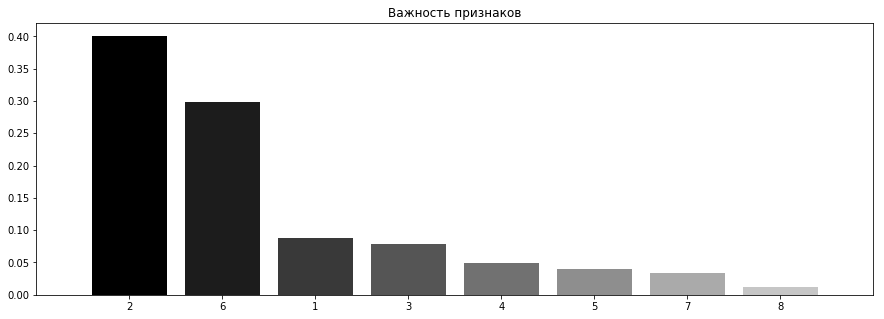

In [42]:
features = X.columns
importances =forest_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importancies of the forest
num_to_plot = len(features)
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features[indices[f]], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность признаков")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
# plt.legend(bars, [u''.join(features["f"+str(i)]) 
#                   for i in indices]);

### #004

In [64]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')
y_train = train['Survived']
X_train = train.drop(['Survived'], axis=1)
X_test = test.copy()

X_full = [X_train, X_test]

def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    else:
        return ""

for df in X_full:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1

    df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
# X_test['IsAlone'] = X_test['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

    df['Embarked'] = df['Embarked'].fillna('S')
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
# X_test['Embarked'] = X_test['Embarked'].fillna('S')

    df['Fare'] = df['Fare'].fillna(X_train['Fare'].median())
# X_test['Fare'] = X_test['Fare'].fillna(X_train['Fare'].median())

    age_mean = X_train['Age'].mean()
    age_std = X_train['Age'].std()
    age_null_count = df['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size=age_null_count)
    df['Age'][np.isnan(df['Age'])] = age_null_random_list
    df['Age'] = df['Age'].astype(int)
# age_null_count = X_test['Age'].isnull().sum()
# age_null_random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size=age_null_count)
# X_test['Age'][np.isnan(X_test['Age'])] = age_null_random_list
# X_test['Age'] = X_test['Age'].astype(int)

    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)
# X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1}).astype(int)
    
    df['Title'] = df['Name'].apply(get_title)
# X_test['Title'] = X_test['Name'].apple(get_title)

    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                       'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)
    
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)
    
    # Mapping Age
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age'] = 4
    
    df.drop(['Name', 'Ticket', 'Cabin', 'SibSp'], axis=1, inplace=True)

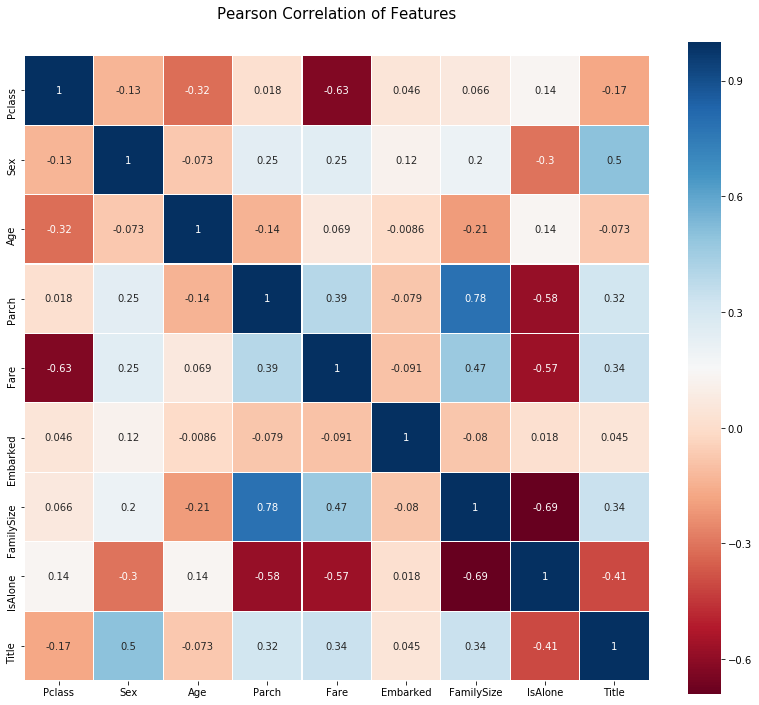

In [58]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);

In [65]:
forest_clf = RandomForestClassifier(n_estimators=500, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1, 
#                                  oob_score=True, 
                                 max_depth=8,
                                 min_samples_leaf=1,
                                 max_features=7)
forest_clf.fit(X_train, y_train)
y_preds = forest_clf.predict(X_test)

### Submission #004

In [66]:
y_fin = pd.DataFrame(y_preds, columns=['Survived'], index=X_test.index)

In [67]:
y_fin.Survived.value_counts()

0    252
1    166
Name: Survived, dtype: int64

In [68]:
y_fin.to_csv('submissions/randomforest_004.csv', header=True, index_label='PassengerId')